## Parse patient zero results - WORK

In [1]:
import numpy as np
import numba as nb
import pandas as pd

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../../../src')
import networkx as nx

In [2]:
import io_m.libsaving as libsaving
import io_m.io_utils as io_utils

from importlib import reload

In [3]:
from epigen import epidemy_gen

In [4]:
from epigen.base import EpInstance

In [5]:
type_graph="i_bird"
N=10
d=3
height=3
lam=0.5
mu=0.02
t_limit=12
scale=2
#gamma=1e-3
#path_contacts="../patient_zero/work/work_13_contacts.npz"
#small_lambda_limit=0

gamma=1e-3
small_lambda_limit=0
path_contacts="work_13_contacts.npz"

p_edge=1
nsrc=1


In [11]:
seeds=range(1,2)

In [12]:
INSTANCES = {s:EpInstance(type_graph, N, d, t_limit, 
                                    lam, mu, s, float(p_edge), 
                                    n_source=nsrc) for s in seeds}

In [13]:
str(INSTANCES[1])

'i_bird_n_10_d_3_tlim_12_lam_0.5_mu_0.02_s_1_pe_1.0'

In [14]:
extra_gen = {"h":height,
            "scale":scale}

extra_gen.update({"gamma":gamma, 
                  "small_lambda_limit":small_lambda_limit, 
                  "path_contacts": path_contacts})

In [15]:

start_conf=0
num_conf=50

In [16]:
%%capture
reload(epidemy_gen)
DATA_ALL = {s: 
            epidemy_gen.epidemy_gen_epinstance(inst, 
                                               lim_infected=1, num_conf=num_conf,
                                               extra_gen=extra_gen, 
                                               verbose=False,
                                              num_sources=nsrc) 
            for s, inst in INSTANCES.items()}

In [17]:
confs={s: np.array(mdata["test"]) for s, mdata in DATA_ALL.items()}

final_confs = {
    s: c[...,1,:] for s, c in confs.items()
} #np.stack(tuple(confs.values()) )[...,1,:]


idx_source = {k: np.stack((np.where(c[0]==1)[0] for c in x)) for k, x in confs.items()}

/home/fmazza/app/miniconda3/envs/torche/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


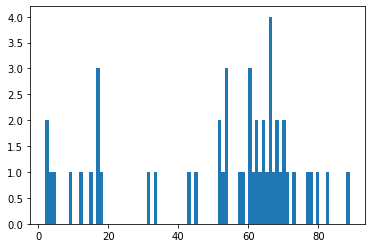

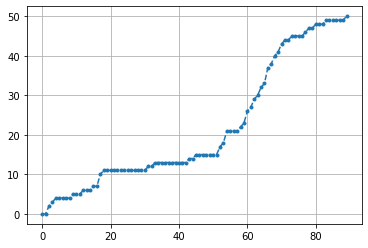

In [18]:
r = np.stack(tuple(final_confs.values())).sum(-1).flatten()
plt.figure()
plt.hist(r,bins=max(r)+1)

plt.figure()
x,vals = np.unique(r, return_counts=True)
allvals = np.zeros(max(x)+1)
allvals[x] = vals
plt.plot(allvals.cumsum(),".--")
plt.grid()

In [19]:
from epigen import generators

In [20]:
EPIDEMIES = {s: generators.calc_epidemies(mdata["epidemy"], mdata["test"], t_limit) 
             for s, mdata in DATA_ALL.items()}

## Read marginals

In [21]:
from io_m import read_results

In [22]:
def load_many_inst(method, folder, instances, *args, **kwargs):
    #if "legacy" in kwargs.keys():
    #    for inst in 
    return {s: method(folder, inst, *args,**kwargs) for s, inst in instances.items()}

In [23]:
margs_all = {}

In [24]:
reload(read_results)

<module 'io_m.read_results' from '../../../src/io_m/read_results.py'>

In [25]:
for inst in INSTANCES.values():
    inst.p_edge=int(inst.p_edge)

In [26]:
confs_load=(0,num_conf)

In [27]:
folder=f"data/"
#folder=f"sib/{INSTANCE.type_graph}_nsrc{nsrc}/"
name_file=""
margs_all["sib"] =load_many_inst(read_results.read_sib_data_def,
                                        #"sib/{type_graph}_nsrc1/",
                                        folder+"sib",
                                        #f"sib/{type_graph}/",
                                        INSTANCES, height, name_file,
                                        range_confs=confs_load, outprint=False)

In [23]:
margs_all["sib_new"] =load_many_inst(read_results.read_sib_data_def,
                                        #"sib/{type_graph}_nsrc1/",
                                        folder+"sib_n",
                                        #f"sib/{type_graph}/",
                                        INSTANCES, height, name_file,
                                        range_confs=confs_load, outprint=False)

## ANN results

In [24]:
reload(read_results)

<module 'io_m.read_results' from '../../../src/io_m/read_results.py'>

In [25]:
del margs_all["ann_old"]

KeyError: 'ann_old'

In [26]:
margs_all["ann_old"] = load_many_inst(read_results.read_margs_default,
                                        #"sib/{type_graph}_nsrc1/",
                                        folder+"ann",
                                        #f"sib/{type_graph}/",
                                        INSTANCES, h=height, prefix=name_file, algo="ann",
                                        range_confs=confs_load, outprint=False, pedge_float=False)

In [28]:
margs_all["ann_3lpow1"] = load_many_inst(read_results.read_margs_inst,
                                        #"sib/{type_graph}_nsrc1/",
                                        "data/ann_3lpow1",
                                        #f"sib/{type_graph}/",
                                        INSTANCES, prefix=name_file,
                                        range_confs=confs_load, outprint=False)

In [ ]:
margs_all["ann_deep_eq"] = load_many_inst(read_results.read_margs_inst,
                                        #"sib/{type_graph}_nsrc1/",
                                        "data/ann_deep",
                                        #f"sib/{type_graph}/",
                                        INSTANCES, prefix=name_file,
                                        range_confs=confs_load, outprint=False)

In [29]:
margs_all["ann_less_deep"] = load_many_inst(read_results.read_margs_inst,
                                        #"sib/{type_graph}_nsrc1/",
                                        "data/ann_less_deep/",
                                        #f"sib/{type_graph}/",
                                        INSTANCES, prefix=name_file,
                                        range_confs=confs_load, outprint=False)

## Soft Margin

In [30]:
from pathlib import Path

In [86]:
import importlib

In [87]:
importlib.reload(sys.modules["soft_margin.saving"])

<module 'soft_margin.saving' from '../../../src/soft_margin/saving.py'>

In [88]:
from soft_margin.saving import load_data_softmargin

In [32]:
def load_softm_res(instance, path_fold, nsim_r, nc, verbose=False):
    smfold=Path(path_fold)
    base_file_name = (smfold / (str(instance)+f"_nc_{nc}_softm_nsims_{nsim_r}_rep_0")).as_posix()
    if verbose: print(base_file_name)
    res = load_data_softmargin(base_file_name)
    return res

In [33]:
from collections import defaultdict

In [34]:
softm_data = defaultdict(dict)
probs_softm = defaultdict(dict)

In [35]:
nsims_softm=np.array([1,10,100])*int(1e6)
nsims_softm

array([  1000000,  10000000, 100000000])

In [89]:
for s, inst in INSTANCES.items():
    for nsim in nsims_softm:
        #print(s, nsim)
        nsim = int(nsim)
        softm_data[s][nsim]=load_softm_res(inst, "data/sm_redo/", nsim,nc=num_conf, verbose=False)
        x = softm_data[s][nsim][1]
        probs_softm[s][nsim] = [x[v] for v in sorted(x.keys())]

Skipping  allow_pickle
Skipping  allow_pickle
Skipping  allow_pickle


## Patient zero

In [37]:
N = tuple(INSTANCES.values())[0].n

In [38]:
def get_random_margs(n):
    x = np.random.rand(n,t_limit+1,3)
    return x / x.sum(-1)[...,np.newaxis]

margs_all["random"] = {s: [get_random_margs(INSTANCES[s].n) for _ in range(start_conf, start_conf+num_conf)]
                      for s in DATA_ALL.keys()}

In [39]:
N_inf = {s:[np.sum(np.array(c[1])!=0) for c in mdata["test"] ]
         for s, mdata in DATA_ALL.items()}

In [40]:
sources = {s:
    np.stack( [np.where(np.array(c[0])==1)[0] for c in mdata["test"] ])
           for s, mdata in DATA_ALL.items()}

In [41]:
SOURCE_CANDIDS = {s:
     [np.where(np.array(c[1])!=0)[0] for c in mdata["test"] ]
           for s, mdata in DATA_ALL.items()}

In [42]:
from sklearn.metrics import auc, roc_curve

In [45]:
def get_source_rank(m, msources):
    psources = m[:,0,1]
    idx=psources.argsort()[::-1]

    rg = sum(((idx == s for s in msources)))
    #print(rg)
    return rg.cumsum()

def get_sources_auc(m, msources, m_psrc=False):
    
    if m_psrc: 
        psources = m
    else:
        psources = m[:,0,1]

    idx=psources.argsort()[::-1]
    truey = np.zeros(psources.shape, dtype=int)
    #rg = sum(((idx == s for s in msources)))
    truey[msources] = 1
    #print(rg)
    fpr,tpr,thr= roc_curve(truey, psources)#rg.cumsum()
    return auc(fpr,tpr)

def get_sources_auc_cands(m, msources, cands, m_psrc=False):
    
    if m_psrc: 
        psrc = m
    else:
        psrc = m[:,0,1]
    
    psources = psrc[cands]

    truey = sum(cands == s for s in msources)
    #print(rg)
    fpr,tpr,thr= roc_curve(truey, psources)#rg.cumsum()
    return auc(fpr,tpr)



def get_source_posit(m, msources):
    psources = m[:,0,1]
    idx=psources.argsort()[::-1]
    pos = [np.argmax(idx == s) for s in msources]
    return pos

def get_source_rank_probs(psources, msources):
    idx=psources.argsort()[::-1]
    #print(idx.shape)

    rg = sum((idx == s for s in msources))
    #print(rg)
    #print(rg.shape)
    #print(np.where(idx==msources[0]))
    return rg.cumsum(-1)

In [90]:
ranks_softm = {}
for nsim in nsims_softm:
    
    source_found = np.stack([
                    [
                        [
                            get_source_rank_probs(x, inst_src) #for x  in
                            for x in probs_softm[seed][nsim][i]
                        ]
                        for i, inst_src in enumerate(srcs)
                    ]
                    for seed, srcs in sources.items()
                ])
    #print(source_found.shape)
    #print(source_found)
    
    ranks_softm[nsim] = source_found.sum(0).sum(0)
    #print(ranks_softm)
    #break


In [47]:
pzero_accu = {name: 
            np.stack([
                np.array([get_source_rank(m,source) 
                          for m, source in zip(marg[s], sources[s])])
                for s in sources.keys()
            ]).sum(0).sum(0)
            for name, marg in margs_all.items()}

In [48]:
from analysis.sources import get_src_posit_obs_margs

In [49]:
from utils.common import pretty_print_n

In [50]:
pzero_pos_scaled = {name: 
            np.stack([
                np.array([get_src_posit_obs_margs(m,source, candids) 
                 for m, source, candids in zip(marg[s], sources[s], SOURCE_CANDIDS[s])])
                for s in sorted(sources.keys())
            ])
            for name, marg in margs_all.items()}

In [91]:
pzero_pos_softm = {nsi: 
            np.stack([
                np.array([
                    [get_src_posit_obs_margs(np.stack((np.zeros_like(m),m),axis=1)[:,np.newaxis]
                                                  ,source, candids)
                          for m in probs]
                 for probs, source, candids in zip(probs_softm[s][nsi], sources[s], SOURCE_CANDIDS[s])])
                for s in sorted(sources.keys())
            ])
            for nsi in nsims_softm}

In [52]:
import analysis.generic as analy
reload(analy)

<module 'analysis.generic' from '../../../src/analysis/generic.py'>

1000000
10000000
100000000


(-0.01, 1.01)

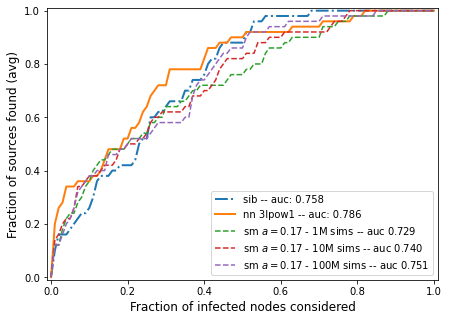

In [104]:
plt.figure(figsize=(7,5))
pars=dict(nbins=100)
d=analy.make_histo_cumsum(pzero_pos_scaled["sib"],**pars)
plt.plot(*d, "-.", label=f"sib -- auc: {auc(*d):.3f}", linewidth="2")

#d=analy.make_histo_cumsum(pzero_pos_scaled["sib_new"],**pars)
#plt.plot(*d, "-.", label=f"sib new -- auc: {auc(*d):.3f}", linewidth="2")

#d=analy.make_histo_cumsum(pzero_pos_scaled["ann_old"],**pars)
#plt.plot(*d, label=f"nn old -- auc: {auc(*d):.3f}", linewidth="2")

d=analy.make_histo_cumsum(pzero_pos_scaled["ann_3lpow1"],**pars)
plt.plot(*d, label=f"nn 3lpow1 -- auc: {auc(*d):.3f}", linewidth="2")


#d=analy.make_histo_cumsum(pzero_pos_scaled["ann_less_deep"],**pars)
#plt.plot(*d, label=f"nn less deep -- auc: {auc(*d):.3f}", linewidth="2")
#d=analy.make_histo_cumsum(pzero_pos_scaled["ann_less_deep"],**pars)
#plt.plot(*d, label=f"nn less deep -- auc: {auc(*d):.3f}", linewidth="2")

#d=analy.make_histo_cumsum(pzero_pos_scaled["ann_3lpow1"],)
#plt.plot(*d, label=f"nn 3lpow1 -- auc: {auc(*d):.3f}", linewidth="2")

d=analy.make_histo_cumsum(pzero_pos_scaled["random"],)
#plt.plot(*d, "-.", label=f"random -- auc: {auc(*d):.3f}")


softm_pars_idx = 16
softm_alpha = tuple(softm_data.values())[0][int(1e6)][0][softm_pars_idx]
for k in nsims_softm:
    print(k)
    d=analy.make_histo_cumsum(pzero_pos_softm[k][..., softm_pars_idx],)
    plt.plot(*d,"--", label="sm $a = {}$ - {} sims -- auc {:.3f}".format(softm_alpha,pretty_print_n(k),
                                                                       auc(*d))) 

plt.legend(loc="lower right")
plt.ylabel("Fraction of sources found (avg)", fontsize="large")
plt.xlabel("Fraction of infected nodes considered",fontsize="large")

plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

In [54]:
pzero_auc = {name: 
            np.stack([
                np.array([get_sources_auc(m,source) for m, source in zip(marg[s], sources[s])])
                for s in sources.keys()
            ]).flatten()
            for name, marg in margs_all.items()}

In [55]:
pzero_auc_onlyI = {name: 
            np.stack([
                np.array([get_sources_auc_cands(m,source, cds) for m, source, cds in zip(marg[s], sources[s], SOURCE_CANDIDS[s])])
                for s in sources.keys()
            ]).flatten()
            for name, marg in margs_all.items()}

In [93]:
softm_pzero_auc = {nsim: 
            np.stack([
                np.array([ [get_sources_auc(p,source,m_psrc=True) for p in m] for m, source in zip(probs_softm[s][nsim], sources[s])])
                for s in sources.keys()
            ])
            for nsim in nsims_softm}

In [94]:
softm_pzero_auc_onlyI = {nsim: 
            np.stack([
                np.array([ [get_sources_auc_cands(p,source,cds,m_psrc=True) for p in m] 
                          for m, source, cds in zip(probs_softm[s][nsim], sources[s],  SOURCE_CANDIDS[s])])
                for s in sources.keys()
            ])
            for nsim in nsims_softm}

In [58]:
for k in sorted(pzero_auc.keys()):
    v = pzero_auc[k]
    print("{}, {:4.3f} \pm {:4.3f} ".format(
        k, np.nanmean(v), np.nanstd(v)/np.sqrt(np.prod(v.shape)-np.isnan(v).sum()))
    )
    #plt.plot(aal, label=k)
    
#plt.legend()

ann_3lpow1, 0.881 \pm 0.017 
ann_less_deep, 0.877 \pm 0.019 
random, 0.565 \pm 0.043 
sib, 0.874 \pm 0.016 


In [59]:
for k in sorted(pzero_auc.keys()):
    v = pzero_auc_onlyI[k]
    print("{}, {:4.3f} \pm {:4.3f} ".format(
        k, np.nanmean(v), np.nanstd(v)/np.sqrt(np.prod(v.shape)-np.isnan(v).sum()))
    )
    #plt.plot(aal, label=k)
    

ann_3lpow1, 0.773 \pm 0.034 
ann_less_deep, 0.765 \pm 0.036 
random, 0.599 \pm 0.045 
sib, 0.742 \pm 0.029 


In [60]:
softm_alphas_all = tuple(softm_data.values())[0][int(1e6)][0]

1000000
10000000
100000000


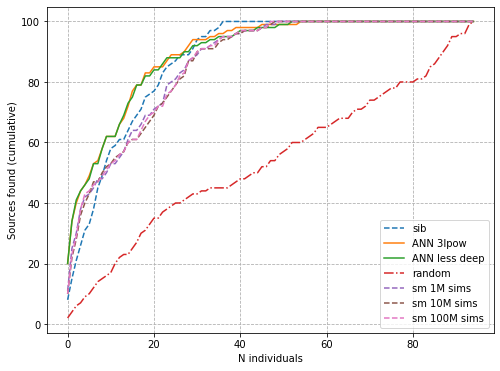

In [63]:
plt.figure(figsize=(8,6))
#for name,x in avg_count_probs.items():
#    plt.plot(x, label=name)
#    print()
#for name,x in avg_count_risk.items():
#    plt.plot(x, label=name)
#plt.plot(ul.mean(0))
x_data = np.arange(N)
#plt.plot(x_data,pzero_accu["sib_psus60"], "--",label="BP")
plt.plot(x_data,pzero_accu["sib"], "--",label="sib")
#, auc: {:4.3f}".format(auc_risk2["sib_psus60"]))
l = "ann_"
#plt.plot(x_data,pzero_accu["ann_psus06_4lpow"], label="ANN")#, auc: {:4.3f}".format(auc_risk2["ann_psus06Fin"]))

#plt.plot(x_data,pzero_accu["ann_less_deep"], label="ANN less deep")
plt.plot(x_data,pzero_accu["ann_3lpow1"], label="ANN 3lpow")
plt.plot(x_data,pzero_accu["ann_less_deep"], label="ANN less deep")

#plt.plot(x_data,pzero_accu["ann_new"], label="ann_new")
#plt.plot(x_data,pzero_accu["ann_new_check"], label="ann_new all nodes")

#plt.plot(x_data,pzero_accu["ann_old_redo"], label="ann_old redo")

plt.plot(x_data,pzero_accu["random"],"-.", label="random")
softm_pars_idx = 25
softm_alpha = softm_alphas_all[softm_pars_idx]
for k in ranks_softm:
    print(k)
    plt.plot(x_data,ranks_softm[k][softm_pars_idx],"--", label="sm {} sims".format(pretty_print_n(k)))


plt.legend()
plt.ylabel("Sources found (cumulative)")
plt.xlabel("N individuals")
plt.grid(linestyle="--")

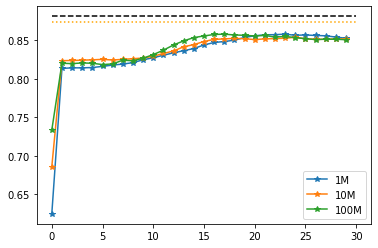

In [101]:
for k in softm_pzero_auc:
    plt.plot(softm_pzero_auc[k].reshape(-1,len(softm_alphas_all)).mean(0).flatten(), "*-", label=pretty_print_n(k))
plt.hlines(pzero_auc["sib"].mean(), 0, 30, colors="orange", linestyles="dotted")

plt.hlines(pzero_auc["ann_3lpow1"].mean(), 0, 30, colors="black", linestyles="dashed")
plt.legend()

In [109]:
softm_pzero_auc_onlyI[int(1e6)].shape

(1, 50, 30)

1000000
10000000
100000000


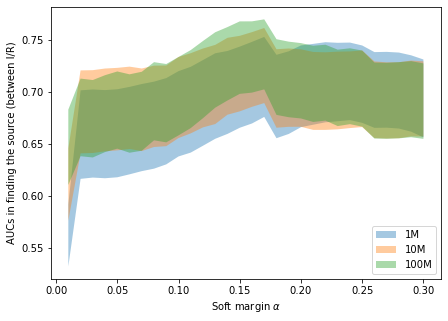

In [123]:
plt.figure(figsize=(7,5))
x=softm_alphas_all
#x = np.arange(len(softm_alphas_all))
for k in softm_pzero_auc_onlyI:
    sac = softm_pzero_auc_onlyI[k].reshape(-1,len(softm_alphas_all))
    mean = sac.mean(0).flatten()
    err = np.nanstd(sac,0).flatten() / np.sqrt(sac.shape[0])
    print(k)
    quas = (np.quantile(sac,[0.4,0.5,0.6], axis=0))
    plt.fill_between(x, mean-err,mean+err,  label=pretty_print_n(k), alpha=0.4) # "*-", label=pretty_print_n(k))

xlims=plt.gca().get_xlim()
#plt.hlines(pzero_auc_onlyI["sib"].mean(), min(x), max(x), colors="orange", linestyles="dotted", label="sib")

#plt.hlines(pzero_auc_onlyI["ann_less_deep"].mean(), min(x), max(x), colors="black", linestyles="dashed", label="ANN less deep")
#plt.hlines(pzero_auc_onlyI["ann_3lpow1"].mean(), min(x), max(x), colors="blue", linestyles="dashdot", label="ANN 3lpow1")

plt.legend(loc="lower right")
plt.xlim(xlims)
plt.xlabel("Soft margin $\\alpha$")
plt.ylabel("AUCs in finding the source (between I/R)")
plt.savefig("SoftmAUC_redo.svg")